This job was done by Théodore DE LEUSSE as part of his internship in the SciNeurotechLab supervised by Marco BONIZZATO.

This file allow us to discover how to use the differents models and to do some comparaison between them. 
What's more, the `A` part shows the quadratic complexity of the method using the Schur complement inversion, compared to the cubic complexity of the commonly used cholesky inverson. 

## A) Compare Schur inversion vs. optimized Cholesky inversion (for online GP)

#### **Objective**: We want to measure how the inversion method with schur complement is faster than with cholesky and the complexity of this inversion. We will use the FixedOnlineGP class for GPs. 

In [1]:
# import lib 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
# import file
from GPcustom.models import FixedOnlineGP, standardize_vector
import time

### B.1) Build the data 

In [2]:
nb_it = 20

# Création de la grille de points dans l'hypercube normalisé (0, 1) x (0, 1)
x_coords = np.linspace(0, 1, 10)
y_coords = np.linspace(0, 1, 10)
X_test_normed = np.array(np.meshgrid(x_coords, y_coords)).T.reshape(-1, 2)

# Génération de train_X en prenant nb_it points aléatoires avec remise dans X_test_normed
train_X_indices = np.random.choice(X_test_normed.shape[0], nb_it, replace=True)
train_X = X_test_normed[train_X_indices]

# Génération de valeurs aléatoires standardisées pour train_Y
train_Y = np.random.randn(nb_it).reshape(-1,1)
train_Y = standardize_vector(train_Y)

### B.2) Simulate the online GPs

In [3]:
rep = 1

gp_dur = np.zeros((2, rep, nb_it))
inv_dur = np.zeros((2, rep, nb_it))

for r in range(rep):
    gp1 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
    gp1.set_kernel()
    gp2 = FixedOnlineGP(input_space=X_test_normed, NB_IT=nb_it, lengthscale=0.4, noise_std=10)
    gp2.set_kernel()
    for i in range(nb_it):

        ## ----- 1st GP with Schur complement method ----- ##
        tic_gp1 = time.perf_counter()
        inv_dur1 = gp1.update(query_x = train_X[i], query_y = train_Y[i])
        gp1.predict()
        tac_gp1 = time.perf_counter()

        ## ----- 2nd GP with Cholesky method ----- ##
        inv_dur2 = gp2.update_no_schur(query_x = train_X[i], query_y = train_Y[i])
        gp2.predict()
        tac_gp2 = time.perf_counter()


        gp_dur[0,r,i] = tac_gp1 - tic_gp1
        gp_dur[1,r,i] = tac_gp2 - tac_gp1
        inv_dur[0,r,i] = inv_dur1
        inv_dur[1,r,i] = inv_dur2   

        if (i + 1) % 100 == 0:
            print(f"we have just done the {i+1} th it for the {r} th rep")  

In [4]:
np.savez("results_custom/gp_and_inv_dur_1rep_20it_sch_and_cho.npz", 
         gp_dur=gp_dur, 
         inv_dur=inv_dur, 
         description="gp_dur: array of shape (2, nb_rep=1, nb_it=20) where gp_dur[0] is the durations of the gp with SCHUR and gp_dur[1] with CHOLESKY\inv_dur: idem but for the inversion of K duration"
         )

 <>:4: SyntaxWarning:invalid escape sequence '\i'
 <>:4: SyntaxWarning:invalid escape sequence '\i'
 C:\Users\deleu\AppData\Local\Temp\ipykernel_34232\1320529407.py:4: SyntaxWarning:invalid escape sequence '\i'


### B.3) Post process

In [5]:
data = np.load("results_custom/gp_and_inv_dur_1rep_10kit_sch_and_cho_new_schur_inv.npz")
print(data['description'])
gp_dur = data['gp_dur']
inv_dur = data['inv_dur']

nb_it = gp_dur.shape[2]
print(nb_it)

gp_dur: array of shape (2, nb_rep=1, nb_it=10000) where gp_dur[0] is the durations of the gp with SCHUR and gp_dur[1] with CHOLESKY
 inv_dur: idem but for the inversion of K duration
 ATTENTION: we have implemented a new schur_inverse function
10000


In [6]:
gp1_duration = np.mean(gp_dur[0], axis= 0)
gp2_duration = np.mean(gp_dur[1], axis= 0)

gp1_duration_std = np.std(gp_dur[0], axis= 0)
gp2_duration_std = np.std(gp_dur[1], axis= 0)

In [7]:
inv1_duration = np.mean(inv_dur[0], axis= 0)
inv2_duration = np.mean(inv_dur[1], axis= 0)

inv1_duration_std = np.std(inv_dur[0], axis= 0)
inv2_duration_std = np.std(inv_dur[1], axis= 0)

#### Plot

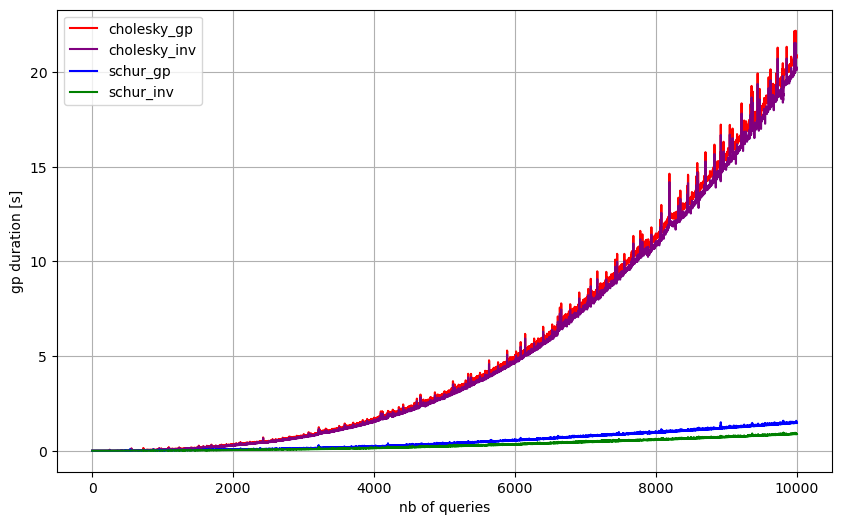

In [8]:
x = np.arange(nb_it)

plt.figure(figsize=(10, 6))

plt.plot(x,gp2_duration, color='red', label='cholesky_gp')
plt.fill_between(x,gp2_duration - gp2_duration_std, gp2_duration + gp2_duration_std, color='lightcoral', alpha=0.5)

plt.plot(x,inv2_duration, color='purple', label='cholesky_inv')
plt.fill_between(x,inv2_duration - inv2_duration_std, inv2_duration + inv2_duration_std, color='lavender', alpha=0.5)

plt.plot(x,gp1_duration, color='blue', label='schur_gp')
plt.fill_between(x,gp1_duration - gp1_duration_std, gp1_duration + gp1_duration_std, color='lightblue', alpha=0.5)

plt.plot(x,inv1_duration, color='green', label='schur_inv')
plt.fill_between(x,inv1_duration - inv1_duration_std, inv1_duration + inv1_duration_std, color='lightgreen', alpha=0.5)

plt.xlabel('nb of queries')
plt.ylabel('gp duration [s]')
plt.legend()
plt.grid()
plt.show()

#### If you want a slightly better curve

In [9]:
def mean_by_interval(vector, n):
    # Check that the vector has a length sufficient for the operation
    if len(vector) < n:
        raise ValueError("The vector length must be greater than or equal to n.")
        
    # Compute means for intervals of 10
    interval_means = [np.mean(vector[i:i+10]) for i in range(0, len(vector) - n)]
    
    return np.array(interval_means)

In [10]:
smooth_int = 20
gp1_duration_s = mean_by_interval(gp1_duration, smooth_int)
gp2_duration_s = mean_by_interval(gp2_duration, smooth_int)
inv1_duration_s = mean_by_interval(inv1_duration, smooth_int)
inv2_duration_s = mean_by_interval(inv2_duration, smooth_int)

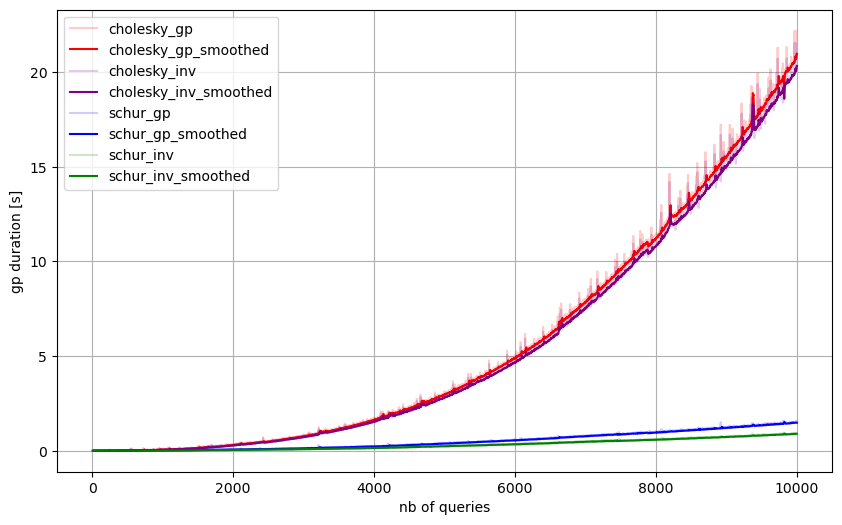

In [11]:
x = np.arange(nb_it)

plt.figure(figsize=(10, 6))

plt.plot(x,gp2_duration, color='red', label='cholesky_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp2_duration_s, color='red', label='cholesky_gp_smoothed')

plt.plot(x,inv2_duration, color='purple', label='cholesky_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv2_duration_s, color='purple', label='cholesky_inv_smoothed')

plt.plot(x,gp1_duration, color='blue', label='schur_gp', alpha=0.2)
plt.plot(x[smooth_int:],gp1_duration_s, color='blue', label='schur_gp_smoothed')

plt.plot(x,inv1_duration, color='green', label='schur_inv', alpha=0.2)
plt.plot(x[smooth_int:],inv1_duration_s, color='green', label='schur_inv_smoothed')

plt.xlabel('nb of queries')
plt.ylabel('gp duration [s]')
plt.legend()
plt.grid()
plt.show()

#### Loglog plot

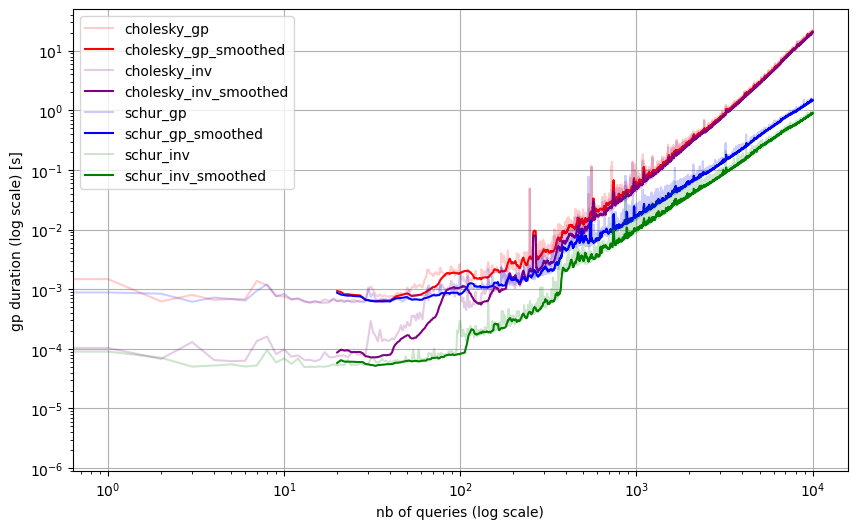

In [12]:
plt.figure(figsize=(10, 6))

plt.loglog(x,gp2_duration, color='red', label='cholesky_gp', alpha=0.2)
plt.loglog(x[smooth_int:],gp2_duration_s, color='red', label='cholesky_gp_smoothed')

plt.loglog(x,inv2_duration, color='purple', label='cholesky_inv', alpha=0.2)
plt.loglog(x[smooth_int:],inv2_duration_s, color='purple', label='cholesky_inv_smoothed')

plt.loglog(x,gp1_duration, color='blue', label='schur_gp', alpha=0.2)
plt.loglog(x[smooth_int:],gp1_duration_s, color='blue', label='schur_gp_smoothed')

plt.loglog(x,inv1_duration, color='green', label='schur_inv', alpha=0.2)
plt.loglog(x[smooth_int:],inv1_duration_s, color='green', label='schur_inv_smoothed')

plt.xlabel('nb of queries (log scale)')
plt.ylabel('gp duration (log scale) [s]')

plt.legend()
plt.grid()
plt.show()

#### Loglog regression

Whith CHOLESKY : 
Calculated exponent (p): 2.64
Coefficient (alpha): 5.04e-10
Whith SCHUR : 
Calculated exponent (p): 1.97
Coefficient (alpha): 1.15e-08


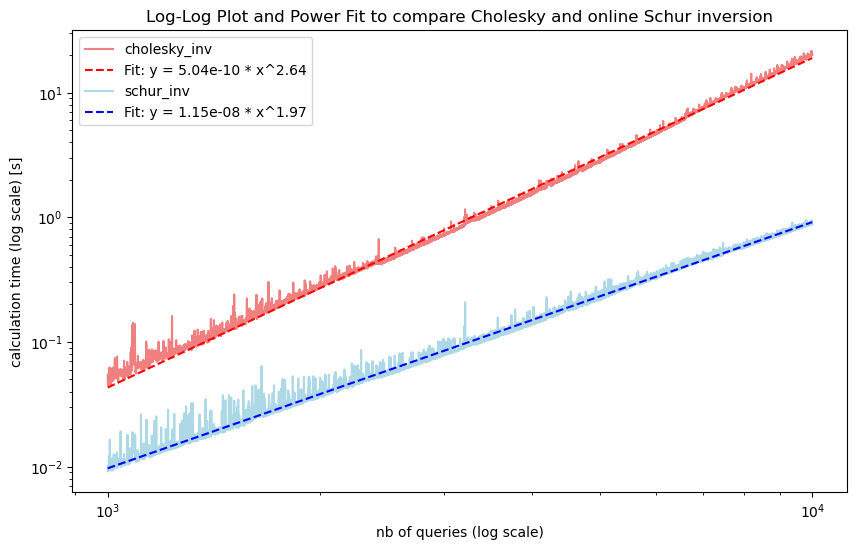

In [13]:
plt.figure(figsize=(10, 6))

## ----- Cholesky ----- ##

# Convert to log scale to fit a line and determine p
log_x = np.log(x[1000:])
log_y = np.log(inv2_duration[1000:])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Display the result for the slope, which corresponds to the power p
print("Whith CHOLESKY : ")
print(f"Calculated exponent (p): {slope:.2f}")
print(f"Coefficient (alpha): {np.exp(intercept):.2e}")

# Plot the log-log graph
plt.loglog(x[1000:], inv2_duration[1000:], label='cholesky_inv', color='lightcoral')
plt.loglog(x[1000:], np.exp(intercept) * x[1000:]**slope, '--', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}', color='red')



## ----- Schur ----- ##

# Convert to log scale to fit a line and determine p
log_x = np.log(x[1000:])
log_y = np.log(inv1_duration[1000:])

# Perform linear regression on the log-log data
slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)

# Display the result for the slope, which corresponds to the power p
print("Whith SCHUR : ")
print(f"Calculated exponent (p): {slope:.2f}")
print(f"Coefficient (alpha): {np.exp(intercept):.2e}")

# Plot the log-log graph
plt.loglog(x[1000:], inv1_duration[1000:], label='schur_inv', color='lightblue')
plt.loglog(x[1000:], np.exp(intercept) * x[1000:]**slope, '--', label=f'Fit: y = {np.exp(intercept):.2e} * x^{slope:.2f}', color='blue')



# Add labels and legend
plt.xlabel('nb of queries (log scale)')
plt.ylabel('calculation time (log scale) [s]')
plt.title('Log-Log Plot and Power Fit to compare Cholesky and online Schur inversion')
plt.legend()
plt.show()

## B) How to use GPcustom.GPytorchModel & GPcustom.GPytorchFixed ? 

In [14]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
from botorch.utils.transforms import standardize

from GPcustom.models import GPytorchModel, GPytorchFixed


### B.1) Input data 

In [15]:

# Générer des données d'entraînement fictives
# Nombre de points d'entraînement
n = 20
train_X = torch.rand(n, 2, dtype=torch.float64)  # Données d'entrée (50 points dans un espace 2D)
train_Y = torch.sin(train_X[:, 0]) + torch.cos(train_X[:, 1]) + 0.1 * torch.randn(n, dtype=torch.float64)  # Fonction cible avec du bruit

train_Y = standardize(train_Y)

print(train_X.shape)
print(train_Y.shape)

torch.Size([20, 2])
torch.Size([20])


### B.2) Build a GPcustom.GPytorchModel, training & update with new queries 

Iter 1/100 - Loss: 1.495   Lengthscale: [1.025000000372529, 1.025000000372529]   Outputscale: 1.750   Noise: 1.001    LR: 0.500
Iter 2/100 - Loss: 1.417   Lengthscale: [0.7862043582084344, 0.786204843770113]   Outputscale: 2.056   Noise: 0.756    LR: 0.500
Iter 3/100 - Loss: 1.346   Lengthscale: [0.5843897135246636, 0.8976653131004133]   Outputscale: 2.089   Noise: 0.539    LR: 0.500
Iter 4/100 - Loss: 1.285   Lengthscale: [0.5399065355280366, 1.0266890056236742]   Outputscale: 1.946   Noise: 0.366    LR: 0.500
Iter 5/100 - Loss: 1.223   Lengthscale: [0.5954718221485754, 1.0198478958844617]   Outputscale: 1.755   Noise: 0.240    LR: 0.500
Iter 6/100 - Loss: 1.174   Lengthscale: [0.69314167537011, 0.910416071586709]   Outputscale: 1.718   Noise: 0.154    LR: 0.500
Iter 7/100 - Loss: 1.147   Lengthscale: [0.7893448009805161, 0.7627138224731812]   Outputscale: 1.833   Noise: 0.099    LR: 0.500
Iter 8/100 - Loss: 1.142   Lengthscale: [0.8257185725406023, 0.6300324345433516]   Outputscale: 

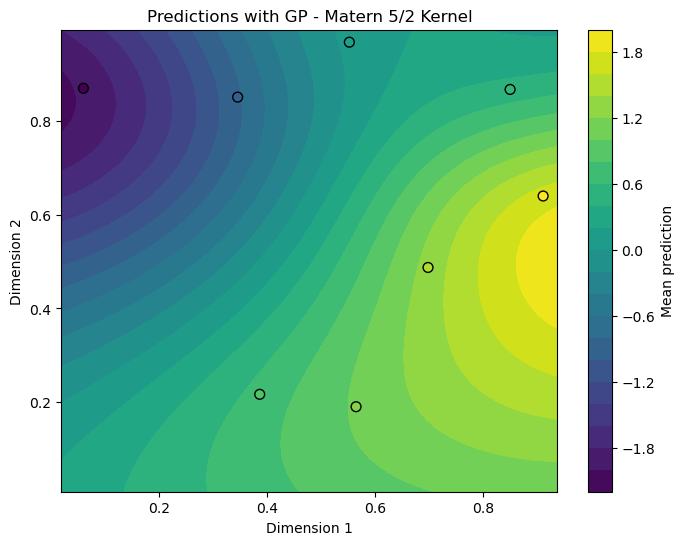

Iter 1/100 - Loss: 0.884   Lengthscale: [0.6482467726280838, 0.4602666943017957]   Outputscale: 2.130   Noise: 0.007    LR: 0.500
Iter 2/100 - Loss: 0.863   Lengthscale: [0.4626713027551465, 0.6451811864950376]   Outputscale: 1.830   Noise: 0.012    LR: 0.500
Iter 3/100 - Loss: 0.851   Lengthscale: [0.5947600792578335, 0.7552747236422346]   Outputscale: 1.574   Noise: 0.018    LR: 0.500
Iter 4/100 - Loss: 0.803   Lengthscale: [0.732288806196793, 0.6941434365003444]   Outputscale: 1.726   Noise: 0.028    LR: 0.500
Iter 5/100 - Loss: 0.804   Lengthscale: [0.8278747654569476, 0.6166399826739678]   Outputscale: 1.924   Noise: 0.043    LR: 0.500
Iter 6/100 - Loss: 0.823   Lengthscale: [0.8579635649657184, 0.5863051953097123]   Outputscale: 2.111   Noise: 0.057    LR: 0.500
Iter 7/100 - Loss: 0.824   Lengthscale: [0.847392527486457, 0.6077327729519727]   Outputscale: 2.260   Noise: 0.062    LR: 0.500
Iter 8/100 - Loss: 0.811   Lengthscale: [0.8246783370122328, 0.6659635740787461]   Outputsca

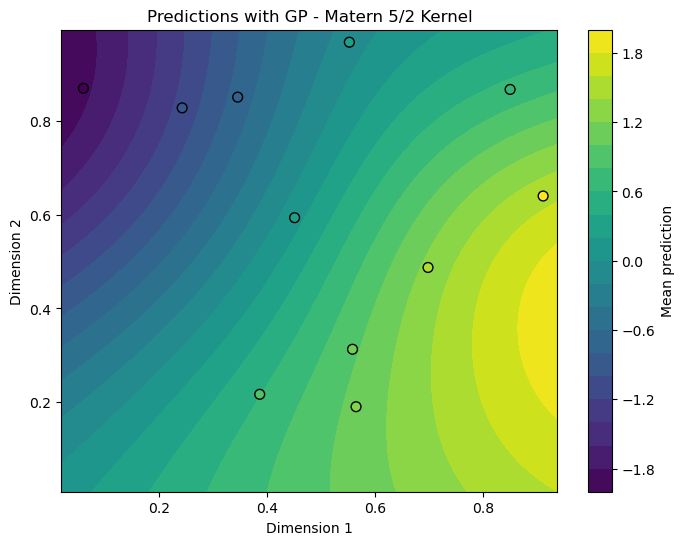

In [16]:
# Define the likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# we will start with n1 points
n1=8

# Initialize the model with Matern 5/2 kernel
model = GPytorchModel(train_X[:n1], train_Y[:n1], likelihood, kernel_type='Matern52')

# Set the model to use double precision
model.double()

# Train the model
optimal_hyperparams = model.train_model(train_X[:n1], train_Y[:n1], max_iters=100, lr=0.5, Verbose=True)

# Display the optimal hyperparameters after convergence
print("Optimal hyperparameters:")
print(optimal_hyperparams)

# Set the model to evaluation mode
model.eval()
likelihood.eval()

# Create a grid for predictions
x_min, x_max = train_X[:, 0].min().item(), train_X[:, 0].max().item()
y_min, y_max = train_X[:, 1].min().item(), train_X[:, 1].max().item()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

# Make a prediction
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = model(grid)

# Reshape the prediction for visualization
pred_mean = observed_pred.mean.reshape(xx.shape)
pred_std = observed_pred.variance.sqrt().reshape(xx.shape)

# Visualize the predictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_mean.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:n1, 0].numpy(), train_X[:n1, 1].numpy(), c=train_Y[:n1].numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions with GP - Matern 5/2 Kernel")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()




### ----- We add 3 more points to the training data ----- ###
n2=n1+3

# Update the model with new training data
model.set_train_data(train_X[:n2], train_Y[:n2], strict=False)

# Train the model again
optimal_hyperparams = model.train_model(train_X[:n2], train_Y[:n2], max_iters=100, lr=0.5, Verbose=True)

# Display the optimal hyperparameters after convergence
print("Optimal hyperparameters:")
print(optimal_hyperparams)

# Set the model to evaluation mode
model.eval()
likelihood.eval()

# Create a grid for predictions
x_min, x_max = train_X[:, 0].min().item(), train_X[:, 0].max().item()
y_min, y_max = train_X[:, 1].min().item(), train_X[:, 1].max().item()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = torch.tensor(np.vstack([xx.ravel(), yy.ravel()]).T, dtype=torch.float32)

# Make a prediction
pred_mean, pred_std = model.predict(grid)

# Reshape the prediction for visualization
pred_mean = pred_mean.reshape(xx.shape)
pred_std = pred_std.reshape(xx.shape)

# Visualize the predictions
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_mean.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:n2, 0].numpy(), train_X[:n2, 1].numpy(), c=train_Y[:n2].numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions with GP - Matern 5/2 Kernel")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

### B.3) Compare GPcustom.GPytorchModel & GPcustom.GPytorchFixed

Iter 1/100 - Loss: 1.244   Lengthscale: [1.025000000372529, 1.025000000372529]   Outputscale: 1.750   Noise: 1.001    LR: 0.100
Iter 2/100 - Loss: 1.224   Lengthscale: [0.9762906080269547, 1.073708440872755]   Outputscale: 1.812   Noise: 0.951    LR: 0.100
Iter 3/100 - Loss: 1.203   Lengthscale: [0.9280877784310709, 1.060811378684989]   Outputscale: 1.874   Noise: 0.901    LR: 0.100
Iter 4/100 - Loss: 1.182   Lengthscale: [0.8810731738666844, 1.0637853829095023]   Outputscale: 1.932   Noise: 0.852    LR: 0.100
Iter 5/100 - Loss: 1.160   Lengthscale: [0.8363119207397539, 1.0847002585360634]   Outputscale: 1.983   Noise: 0.803    LR: 0.100
Iter 6/100 - Loss: 1.139   Lengthscale: [0.7954460289882054, 1.111407758109064]   Outputscale: 2.023   Noise: 0.755    LR: 0.100
Iter 7/100 - Loss: 1.117   Lengthscale: [0.7607642222915652, 1.1326626234856467]   Outputscale: 2.051   Noise: 0.708    LR: 0.100
Iter 8/100 - Loss: 1.095   Lengthscale: [0.7347490683044965, 1.1392087754186644]   Outputscale:

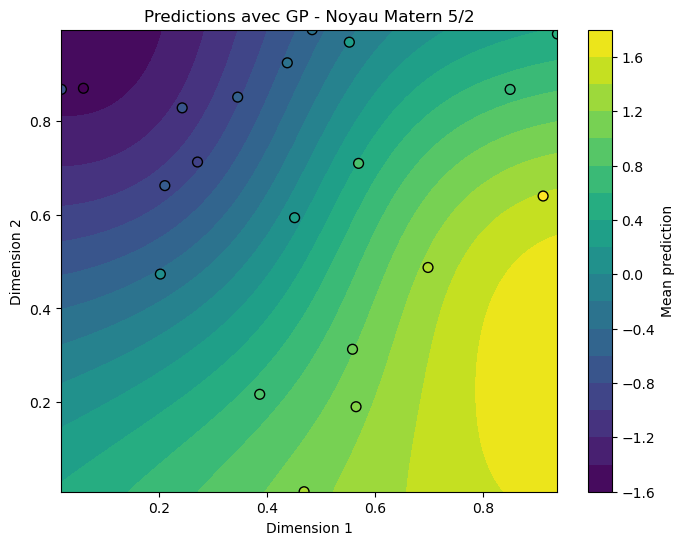

In [17]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPytorchModel(train_X, train_Y, likelihood)


model.double()

model.train_model(train_X, train_Y, max_iters=100, lr=0.1, Verbose=True)


print(model.get_hyperparameters())

mean_pred, std_pred = model.predict(grid)

pred_mean = mean_pred.reshape(xx.shape)
pred_std = std_pred.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_mean.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c=train_Y.numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

{'lengthscale': [0.7128663541456915, 0.8736542097675801], 'outputscale': 1.716318066028156, 'noise': 0.07141950970300319}


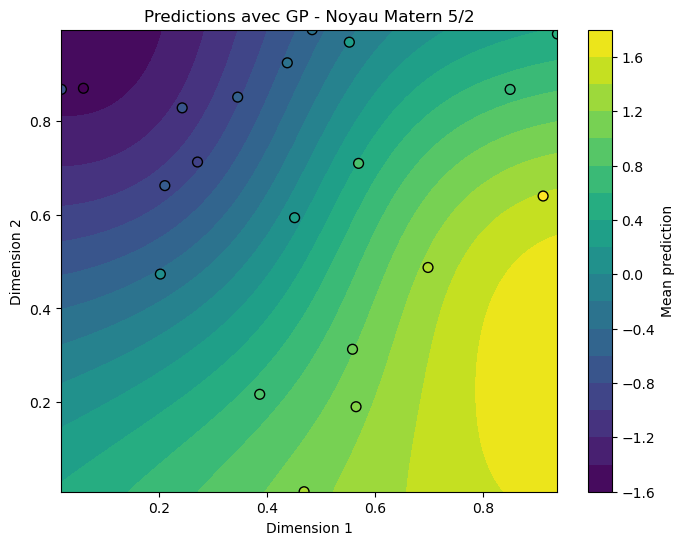

In [18]:
# Example usage
likelihoodb = gpytorch.likelihoods.GaussianLikelihood()

# Fixed hyperparameters
fixed_params = {
    'lengthscale': torch.tensor([model.get_hyperparameters()['lengthscale']], dtype=torch.float64),#torch.tensor([[0.2,0.3]], dtype=torch.float64),
    'outputscale': model.get_hyperparameters()['outputscale'],
    'noise': model.get_hyperparameters()['noise']
}

# Instantiate the fixed GP model
modelb = GPytorchFixed(
    train_X, train_Y, likelihoodb, 
    kernel_type='Matern52',
    **fixed_params
)
modelb.double()
print(modelb.get_hyperparameters())

mean_predb, std_predb = modelb.predict(grid)

pred_meanb = mean_predb.reshape(xx.shape)
pred_stdb = std_predb.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, pred_meanb.numpy(), 20, cmap='viridis')
plt.colorbar(label='Mean prediction')
plt.scatter(train_X[:, 0].numpy(), train_X[:, 1].numpy(), c=train_Y.numpy(), s=50, edgecolor='k', cmap='viridis')
plt.title("Predictions avec GP - Noyau Matern 5/2")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [19]:
print('max diff for the mean pred:  ',torch.max(torch.abs(pred_mean - pred_meanb)).item())
print('max diff for the std pred:  ',torch.max(torch.abs(pred_std - pred_stdb)).item())

max diff for the mean pred:   3.564278916456942e-08
max diff for the std pred:   2.5013209725699426e-08
